In [1]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import seaborn as sns
import yfinance as yf
import torch.optim as optim
import torch.functional as F
from torchviz import make_dot
from tqdm.notebook import tqdm
from datetime import timedelta
import matplotlib.pyplot as plt
from torchsummary import summary
from IPython.display import Image
import plotly.graph_objects as go
#from keras.utils import plot_model
#from keras.models import Sequential
from IPython.display import Image, display
from sklearn.preprocessing import MinMaxScaler
#from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
#from tensorflow.keras.layers import Embedding, SpatialDropout1D, Bidirectional, LSTM, Dense, Dropout
import mplfinance as mpf


In [2]:
def split_data(sequence):
    train_data, test_data = train_test_split(sequence, test_size=0.2, shuffle=False)
    val_data, test_data = train_test_split(test_data, test_size=0.5, shuffle=False)
    return train_data, val_data, test_data

In [3]:
tck = yf.Ticker("INTC")
start_date= "1995-08-1"
end_date = "2025-08-10"
df5 = tck.history(start = start_date, end = end_date)
df5

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1995-08-01 00:00:00-04:00,4.579954,4.579954,4.403802,4.456648,94556800,0.0,0.0
1995-08-02 00:00:00-04:00,4.535917,4.579955,4.298112,4.333342,135620800,0.0,0.0
1995-08-03 00:00:00-04:00,4.210033,4.421415,4.165995,4.377377,117961600,0.0,0.0
1995-08-04 00:00:00-04:00,4.386187,4.439033,4.350957,4.368572,68723200,0.0,0.0
1995-08-07 00:00:00-04:00,4.403802,4.500686,4.386187,4.474263,51580000,0.0,0.0
...,...,...,...,...,...,...,...
2025-08-04 00:00:00-04:00,19.520000,19.590000,19.350000,19.500000,69249400,0.0,0.0
2025-08-05 00:00:00-04:00,19.700001,20.540001,19.680000,20.190001,97338200,0.0,0.0
2025-08-06 00:00:00-04:00,20.120001,20.480000,19.870001,20.410000,67074200,0.0,0.0


In [4]:
df5 = df5.reset_index()
df5['Volume'] = df5['Volume'].astype('float64')

In [5]:
sma_days = [10, 20, 50]
# Calculate SMAs for each window size and add them to the dataframe
for sma in sma_days:
    col_name = f'SMA_{sma}days'
    df5[col_name] = df5['Close'].rolling(sma).mean()

df5['SMA_10days'] = df5['SMA_10days'].fillna(df5['Close'])
df5['SMA_20days'] = df5['SMA_20days'].fillna(df5['Close'])
df5['SMA_50days'] = df5['SMA_50days'].fillna(df5['Close'])

df5.head(15)

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,SMA_10days,SMA_20days,SMA_50days
0,1995-08-01 00:00:00-04:00,4.579954,4.579954,4.403802,4.456648,94556800.0,0.0,0.0,4.456648,4.456648,4.456648
1,1995-08-02 00:00:00-04:00,4.535917,4.579955,4.298112,4.333342,135620800.0,0.0,0.0,4.333342,4.333342,4.333342
2,1995-08-03 00:00:00-04:00,4.210033,4.421415,4.165995,4.377377,117961600.0,0.0,0.0,4.377377,4.377377,4.377377
3,1995-08-04 00:00:00-04:00,4.386187,4.439033,4.350957,4.368572,68723200.0,0.0,0.0,4.368572,4.368572,4.368572
4,1995-08-07 00:00:00-04:00,4.403802,4.500686,4.386187,4.474263,51580000.0,0.0,0.0,4.474263,4.474263,4.474263
5,1995-08-08 00:00:00-04:00,4.527106,4.597566,4.500683,4.562336,58122400.0,0.0,0.0,4.562336,4.562336,4.562336
6,1995-08-09 00:00:00-04:00,4.694451,4.703259,4.615183,4.659221,70807200.0,0.0,0.0,4.659221,4.659221,4.659221
7,1995-08-10 00:00:00-04:00,4.659221,4.668028,4.500684,4.527107,60408000.0,0.0,0.0,4.527107,4.527107,4.527107
8,1995-08-11 00:00:00-04:00,4.632798,4.685643,4.588760,4.659221,68375200.0,0.0,0.0,4.659221,4.659221,4.659221
9,1995-08-14 00:00:00-04:00,4.650413,4.720874,4.606375,4.676836,50202400.0,0.0,0.0,4.509492,4.676836,4.676836


In [6]:
ten_days = df5[['Open','High','Low', 'Volume','SMA_10days','Close']].copy(deep=True)
twenty_days = df5[['Open','High','Low', 'Volume','SMA_20days','Close']].copy(deep=True)
all_sma = df5[['Open','High','Low', 'Volume','SMA_10days','SMA_20days','Close']].copy(deep=True)

In [7]:
# Scaling

# 10 days SMA
scaler = MinMaxScaler(feature_range=(0,2)).fit(ten_days.Low.values.reshape(-1,1))
ten_days['Open'] = scaler.transform(ten_days.Open.values.reshape(-1,1))
ten_days['High'] = scaler.transform(ten_days.High.values.reshape(-1,1))
ten_days['Low'] = scaler.transform(ten_days.Low.values.reshape(-1,1))
ten_days['Volume'] = scaler.transform(ten_days.Volume.values.reshape(-1,1))
ten_days['Close'] = scaler.transform(ten_days.Close.values.reshape(-1,1))
ten_days['SMA_10days'] = scaler.transform(ten_days['SMA_10days'].values.reshape(-1,1))

# 20 days SMA
scaler = MinMaxScaler(feature_range=(0,2)).fit(twenty_days.Low.values.reshape(-1,1))
twenty_days['Open'] = scaler.transform(twenty_days.Open.values.reshape(-1,1))
twenty_days['High'] = scaler.transform(twenty_days.High.values.reshape(-1,1))
twenty_days['Low'] = scaler.transform(twenty_days.Low.values.reshape(-1,1))
twenty_days['Volume'] = scaler.transform(twenty_days.Volume.values.reshape(-1,1))
twenty_days['Close'] = scaler.transform(twenty_days.Close.values.reshape(-1,1))
twenty_days['SMA_20days'] = scaler.transform(twenty_days['SMA_20days'].values.reshape(-1,1))

# Both 10 & 20 days SMA
scaler = MinMaxScaler(feature_range=(0,2)).fit(all_sma.Low.values.reshape(-1,1))
all_sma['Open'] = scaler.transform(all_sma.Open.values.reshape(-1,1))
all_sma['High'] = scaler.transform(all_sma.High.values.reshape(-1,1))
all_sma['Low'] = scaler.transform(all_sma.Low.values.reshape(-1,1))
all_sma['Volume'] = scaler.transform(all_sma.Volume.values.reshape(-1,1))
all_sma['Close'] = scaler.transform(all_sma.Close.values.reshape(-1,1))
all_sma['SMA_10days'] = scaler.transform(all_sma['SMA_10days'].values.reshape(-1,1))
all_sma['SMA_20days'] = scaler.transform(all_sma['SMA_20days'].values.reshape(-1,1))

In [8]:
# rescaled dataframes 
data_10days = ten_days[['Open','High','Low', 'SMA_10days','Close']].values
data_20days = twenty_days[['Open','High','Low','SMA_20days','Close']].values
data_all = all_sma[['Open','High','Low', 'SMA_10days','SMA_20days','Close']].values

In [9]:
print(data_10days.shape)
print(data_20days.shape)
print(data_all.shape)

(7556, 5)
(7556, 5)
(7556, 6)


In [10]:
# using the price of the previous 10 days to predict the next day price
seq_len = 11

# 10 days SMA sequence
sequence_10days = []
for index in range(len(data_10days) - seq_len + 1): 
    sequence_10days.append(data_10days[index: index + seq_len])
sequence_10days = np.array(sequence_10days)
print(sequence_10days.shape)

# 20 days SMA sequence
sequence_20days = []
for index in range(len(data_20days) - seq_len + 1): 
    sequence_20days.append(data_20days[index: index + seq_len])
sequence_20days = np.array(sequence_20days)
print(sequence_20days.shape)

# Both SMAs sequence
sequence_all = []
for index in range(len(data_all) - seq_len + 1): 
    sequence_all.append(data_all[index: index + seq_len])
sequence_all = np.array(sequence_all)
print(sequence_all.shape)

(7546, 11, 5)
(7546, 11, 5)
(7546, 11, 6)


In [11]:
# split data
train_data_10days, val_data_10days, test_data_10days = split_data(sequence_10days)
train_data_20days, val_data_20days, test_data_20days = split_data(sequence_20days)
train_data_all, val_data_all, test_data_all = split_data(sequence_all)

In [12]:
ORANGE = "\033[38;5;214m"
RESET = "\033[0m"

# Check shapes of the split data
print(f"{ORANGE}Shapes:\n{RESET}")
print(f"{ORANGE}10 days SMA sequence:{RESET}")
print(f"{ORANGE}Train:{RESET} {train_data_10days.shape} {ORANGE}Validation:{RESET} {val_data_10days.shape} {ORANGE}Test:{RESET} {test_data_10days.shape}")
print(f"{ORANGE}20 days SMA sequence:{RESET}")
print(f"{ORANGE}Train:{RESET} {train_data_20days.shape} {ORANGE}Validation:{RESET} {val_data_20days.shape} {ORANGE}Test:{RESET} {test_data_20days.shape}")
print(f"{ORANGE}Both SMAs sequence:{RESET}")
print(f"{ORANGE}Train:{RESET} {train_data_all.shape} {ORANGE}Validation:{RESET} {val_data_all.shape} {ORANGE}Test:{RESET} {test_data_all.shape}")

Shapes:

10 days SMA sequence:
Train: (6036, 11, 5) Validation: (755, 11, 5) Test: (755, 11, 5)
20 days SMA sequence:
Train: (6036, 11, 5) Validation: (755, 11, 5) Test: (755, 11, 5)
Both SMAs sequence:
Train: (6036, 11, 6) Validation: (755, 11, 6) Test: (755, 11, 6)


In [13]:
# Split X and Y for each dataset
def split_Xy(dataset):
    # Extract features (X) and target (Y)
    X = dataset[:, :-1, :]
    Y = dataset[:, -1, -1]   #last column (close price)
    return X, Y
# Split X and Y for each dataset
x_train_10d, y_train_10d = split_Xy(train_data_10days)
x_val_10d, y_val_10d = split_Xy(val_data_10days)
x_test_10d, y_test_10d = split_Xy(test_data_10days)
x_train_20d, y_train_20d = split_Xy(train_data_20days)
x_val_20d, y_val_20d = split_Xy(val_data_20days)
x_test_20d, y_test_20d = split_Xy(test_data_20days)
x_train_all, y_train_all = split_Xy(train_data_all)
x_val_all, y_val_all = split_Xy(val_data_all)
x_test_all, y_test_all = split_Xy(test_data_all)
print(x_train_10d.shape, y_train_10d.shape)
print(x_val_10d.shape, y_val_10d.shape)

(6036, 10, 5) (6036,)
(755, 10, 5) (755,)


In [14]:
# dataloader

batch_size = 64
# 10 days SMA
x_train_10d = torch.tensor(x_train_10d).float()
y_train_10d = torch.tensor(y_train_10d).float()
x_val_10d = torch.tensor(x_val_10d).float()
y_val_10d = torch.tensor(y_val_10d).float()
train_set_10d = TensorDataset(x_train_10d,y_train_10d)
train_dataloader_10d = DataLoader(train_set_10d, batch_size=32, shuffle=False)
val_set_10d = TensorDataset(x_val_10d ,y_val_10d)
val_dataloader_10d = DataLoader(val_set_10d, batch_size=32, shuffle=False)


# 20 days SMA
x_train_20d = torch.tensor(x_train_20d).float()
y_train_20d = torch.tensor(y_train_20d).float()
x_val_20d = torch.tensor(x_val_20d).float()
y_val_20d = torch.tensor(y_val_20d).float()
train_set_20d = TensorDataset(x_train_20d,y_train_20d)
train_dataloader_20d = DataLoader(train_set_20d, batch_size=32, shuffle=False)
val_set_20d = TensorDataset(x_val_20d, y_val_20d)
val_dataloader_20d = DataLoader(val_set_20d, batch_size=32, shuffle=False)

# 10 & 20 days SMA
x_train_all = torch.tensor(x_train_all).float()
y_train_all = torch.tensor(y_train_all).float()
x_val_all = torch.tensor(x_val_all).float()
y_val_all = torch.tensor(y_val_all).float()
train_set_all = TensorDataset(x_train_all,y_train_all)
train_dataloader_all = DataLoader(train_set_all, batch_size=32, shuffle=False)
val_set_all = TensorDataset(x_val_all,y_val_all)
val_dataloader_all = DataLoader(val_set_all, batch_size=32, shuffle=False)

In [15]:
class NeuralNetwork(nn.Module):
    def __init__(self, num_feature):
        super(NeuralNetwork, self).__init__()
        self.lstm = nn.LSTM(num_feature, 64, batch_first=True)  # 64 represents the number of hidden units in the LSTM layer
        self.dropout = nn.Dropout(p=0.5)  # Adding Dropout layer with a dropout probability of 0.5
        self.fc = nn.Linear(64, num_feature)

    def forward(self, x):
        output, (hidden, cell) = self.lstm(x)
        x = self.dropout(hidden[-1])  # Apply dropout to the last hidden state
        x = self.fc(x)
        return x

mse = nn.MSELoss()
epochs = 50

In [16]:
def train(model, dataloader, optimizer, criterion):
    model.train()  
    epoch_loss = 0
    
    for inputs, target in dataloader:
        optimizer.zero_grad()  
        # Forward pass
        prediction = model(inputs)  
        target = target.unsqueeze(-1)  # Reshape target to match prediction shape
        loss = criterion(prediction, target)  # Calculate the loss
        
        loss.backward()  # Backward pass
        optimizer.step()  # Optimize

        epoch_loss += loss.item()

    return epoch_loss

In [17]:
def evaluate(model, dataloader, criterion):
    model.eval()  
    epoch_loss = 0
    
    with torch.no_grad():
        for inputs, target in dataloader:
            prediction = model(inputs) 
            target = target.unsqueeze(-1)  # Reshape target to match prediction shape
            loss = criterion(prediction, target)  # Calculate the loss
            
            epoch_loss += loss.item()

    return epoch_loss / len(dataloader)

Model architecture saved as 'model_lstm.png'.


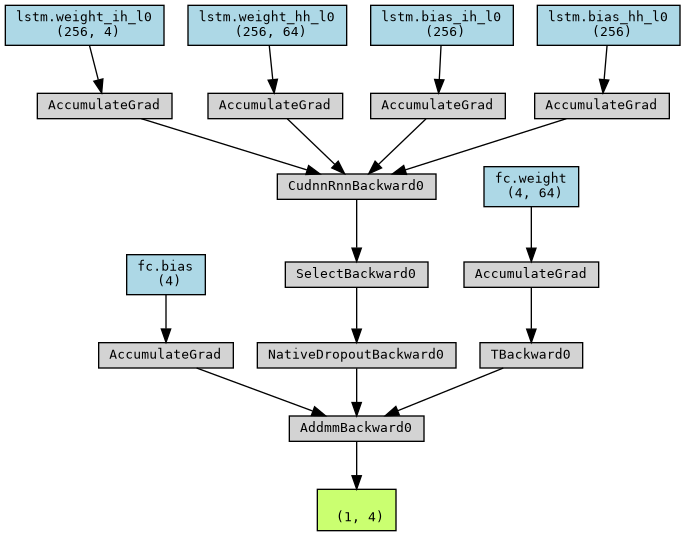

In [18]:
# Create the model instance
num_feature = 4  # Adjust this according to your features
model = NeuralNetwork(num_feature)

# Push to CUDA if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Generate a random input tensor
x = torch.randn(1, 10, num_feature).to(device)  # (batch_size, sequence_length, num_features)

# Visualize the model architecture using torchviz
try:
    y = model(x)  # Forward pass to generate graph
    graph = make_dot(y, params=dict(model.named_parameters()))
    graph.render("model_lstm", format="png")  # Save as PNG
    print("Model architecture saved as 'model_lstm.png'.")

    # Display the saved image in the Jupyter Notebook
    display(Image(filename="model_lstm.png"))
except Exception as e:
    print(f"Error plotting model architecture: {e}")